In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
from extreme_deconvolution.extreme_deconvolution import extreme_deconvolution as xd
from scipy.stats import norm, multinomial, uniform, multivariate_normal
from scipy.linalg import inv
import scipy as sp
from mcmcplotting import convert_to_stdev_nan

from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

rc('font', family='sans', size=18)
rc('xtick.major', size='6')
rc('xtick.minor', size='4')
rc('ytick.major', size='6')
rc('ytick.minor', size='4')
rc('lines', linewidth=2.0)
rc('axes', linewidth=1)
rc('xtick', direction='out')
rc('ytick', direction='out')
rc('grid', color='cbcbcb')
rc('grid', linestyle='-')
rc('grid', linewidth=0.5)
rc('grid', alpha=1.0)
rc('figure', facecolor='ffffff')
rc('figure', dpi=80)
rc('figure.subplot', bottom=0.125)

# Read Bovy et al 2009 velocity components (defined in Galactic coordinates)
bovyvelfield = np.genfromtxt('bovy2009_velocity_field.txt', names=True, delimiter=',')

# Simulate a collection of stars distributed at constant space density around the sun, 
# with distances between 1 and 500 pc. Use Galactic coordinates. Each star is assigned
# a 3D space velocity drawn from a superposition of several 3D normal distributions in 
# velocity space.
rmin = 1.0
rmax = 500.0
Nstars = 50000
r = np.power(rmin**3 + uniform.rvs(size=Nstars)*(rmax**3-rmin**3), 1.0/3.0)
galon = uniform.rvs(size=Nstars)*np.pi*2
galat = np.arccos(uniform.rvs(size=Nstars)*2-1)-np.pi/2

x_gal, y_gal, z_gal = sphericalToCartesian(r, galon, galat)

# Define the space velocities (u,v,w), again in galactic coordinates
"""
ncomponents = bovyvelfield['j'].size
means = []
covmats = []
for i in range(ncomponents):
    means.append(np.array([bovyvelfield[i]['m_x'], bovyvelfield[i]['m_y'], bovyvelfield[i]['m_z']]))
    covmat = np.zeros((3,3))
    covmat[0][0] = bovyvelfield[i]['sxx']
    covmat[1][1] = bovyvelfield[i]['syy']
    covmat[2][2] = bovyvelfield[i]['szz']
    covmat[0][1] = bovyvelfield[i]['sxy']
    covmat[0][2] = bovyvelfield[i]['sxz']
    covmat[1][2] = bovyvelfield[i]['syz']
    covmat[1][0] = covmat[0][1]
    covmat[2][0] = covmat[0][2]
    covmat[2][1] = covmat[1][2]
    covmats.append(covmat)
    
assign_to_component = multinomial.rvs(1, bovyvelfield['alpha_j'], size=Nstars)
"""
amps = [0.5, 0.5]
ncomponents = len(amps)
means = [[ 0., 0., 0.], [10., 10., 10.]]
covmats = [[[100., 0., 0.], [0., 100., 0.], [0., 0., 100.]],
           [[100., 0., 0.], [0., 100., 0.], [0., 0., 100.]]]
assign_to_component = multinomial.rvs(1, amps, size=Nstars)

uvw_gal = np.zeros((Nstars,3))
for kk in range(ncomponents):
    uvw_gal[assign_to_component[:,kk]==1,:] = \
    multivariate_normal.rvs(size=np.sum(assign_to_component[:,kk]==1), mean=means[kk], cov=covmats[kk])

amps_true = amps
means_true = means
covmats_true = covmats

"""    
fig = plt.figure(figsize=(16,5))
axA = fig.add_subplot(1,3,1)
axA.hist(uvw_gal[:,0], bins='auto', histtype='step', normed=True, lw=3)
x = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)
pdfu = np.zeros_like(x)
for k in range(ncomponents):
    pdfu = pdfu + bovyvelfield['alpha_j'][k]*norm.pdf(x, loc=means[k][0], scale=np.sqrt(covmats[k][0,0]))
axA.plot(x, pdfu)
axA.set_xlabel('$U$ [km/s]')

axB = fig.add_subplot(1,3,2)
axB.hist(uvw_gal[:,1], bins='auto', histtype='step', normed=True, lw=3)
x = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)
pdfv = np.zeros_like(x)
for k in range(ncomponents):
    pdfv = pdfv + bovyvelfield['alpha_j'][k]*norm.pdf(x, loc=means[k][1], scale=np.sqrt(covmats[k][1,1]))
axB.plot(x, pdfv)
axB.set_xlabel('$V$ [km/s]')

axC = fig.add_subplot(1,3,3)
axC.hist(uvw_gal[:,2], bins='auto', histtype='step', normed=True, lw=3)
x = np.linspace(uvw_gal[:,2].min(), uvw_gal[:,2].max(), 1000)
pdfw = np.zeros_like(x)
for k in range(ncomponents):
    pdfw = pdfw + bovyvelfield['alpha_j'][k]*norm.pdf(x, loc=means[k][2], scale=np.sqrt(covmats[k][2,2]))
axC.plot(x, pdfw)
axC.set_xlabel('$W$ [km/s]')

plt.suptitle("Simulated velocities in Galactic Cartesian coordinates")
plt.tight_layout(pad=1.8)

figB = plt.figure(figsize=(8,8))
axBA = figB.add_subplot(111)
u=np.linspace(-130,120,251)
v=np.linspace(-120,60,181)
uu, vv = np.meshgrid(u,v)
pdfuv = np.zeros_like(uu)
uvpos = np.dstack((uu,vv))
for k in range(ncomponents):
    pdfuv = pdfuv + bovyvelfield['alpha_j'][k] * \
        multivariate_normal.pdf(uvpos, mean=means[k][0:2], cov=covmats[k][0:2,0:2])
axBA.hexbin(uvw_gal[:,0], uvw_gal[:,1], gridsize=251, bins='log', mincnt=1)
#axBA.hist2d(uvw_gal[:,0], uvw_gal[:,1], bins=[250, 180], cmin=0, range=[[-130,120],[-120,60]], norm=LogNorm())
axBA.contour(u, v, convert_to_stdev_nan(np.log(pdfuv)), levels=np.array([2,6,12,21,33,50,68,80,90,95,99])/100.0, 
             colors='k', linewidths=1)
axBA.set_xlim(-130,120)
axBA.set_ylim(-120,60)
axBA.set_xlabel('$U$ [km/s]')
axBA.set_ylabel('$V$ [km/s]')

figC = plt.figure(figsize=(8,8))
axCA = figC.add_subplot(111)
w=np.linspace(-80,80,161)
uu, ww = np.meshgrid(u,w)
pdfuw = np.zeros_like(uu)
uwpos = np.dstack((uu,ww))
for k in range(ncomponents):
    m = np.array([means[k][0],means[k][2]])
    c = np.array([ [covmats[k][0,0],covmats[k][0,2]], [covmats[k][2,0],covmats[k][2,2]] ])
    pdfuw = pdfuw + bovyvelfield['alpha_j'][k] * multivariate_normal.pdf(uwpos, mean=m, cov=c)
axCA.hexbin(uvw_gal[:,0], uvw_gal[:,2], gridsize=251, bins='log', mincnt=1)
#axCA.hist2d(uvw_gal[:,0], uvw_gal[:,2], bins=[250, 160], cmin=0, range=[[-130,120],[-80,80]], norm=LogNorm())
axCA.contour(u, w, convert_to_stdev_nan(np.log(pdfuw)), levels=np.array([2,6,12,21,33,50,68,80,90,95,99])/100.0, 
             colors='k', linewidths=1)
axCA.set_xlim(-130,120)
axCA.set_ylim(-80,80)
axCA.set_xlabel('$U$ [km/s]')
axCA.set_ylabel('$W$ [km/s]')

figD = plt.figure(figsize=(8,8))
axDA = figD.add_subplot(111)
vv, ww = np.meshgrid(v,w)
pdfvw = np.zeros_like(vv)
vwpos = np.dstack((vv,ww))
for k in range(ncomponents):
    pdfvw = pdfvw + bovyvelfield['alpha_j'][k] * \
        multivariate_normal.pdf(vwpos, mean=means[k][1:3], cov=covmats[k][1:3,1:3])
axDA.hexbin(uvw_gal[:,1], uvw_gal[:,2], gridsize=181, bins='log', mincnt=1)
#axDA.hist2d(uvw_gal[:,1], uvw_gal[:,2], bins=[180, 160], cmin=0, range=[[-120,60],[-80,80]], norm=LogNorm())
axDA.contour(v, w, convert_to_stdev_nan(np.log(pdfvw)), levels=np.array([2,6,12,21,33,50,68,80,90,95,99])/100.0, 
             colors='k', linewidths=1)
axDA.set_xlim(-120,60)
axDA.set_ylim(-80,80)
axDA.set_xlabel('$V$ [km/s]')
axDA.set_ylabel('$W$ [km/s]')

plt.show()"""

'    \nfig = plt.figure(figsize=(16,5))\naxA = fig.add_subplot(1,3,1)\naxA.hist(uvw_gal[:,0], bins=\'auto\', histtype=\'step\', normed=True, lw=3)\nx = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)\npdfu = np.zeros_like(x)\nfor k in range(ncomponents):\n    pdfu = pdfu + bovyvelfield[\'alpha_j\'][k]*norm.pdf(x, loc=means[k][0], scale=np.sqrt(covmats[k][0,0]))\naxA.plot(x, pdfu)\naxA.set_xlabel(\'$U$ [km/s]\')\n\naxB = fig.add_subplot(1,3,2)\naxB.hist(uvw_gal[:,1], bins=\'auto\', histtype=\'step\', normed=True, lw=3)\nx = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)\npdfv = np.zeros_like(x)\nfor k in range(ncomponents):\n    pdfv = pdfv + bovyvelfield[\'alpha_j\'][k]*norm.pdf(x, loc=means[k][1], scale=np.sqrt(covmats[k][1,1]))\naxB.plot(x, pdfv)\naxB.set_xlabel(\'$V$ [km/s]\')\n\naxC = fig.add_subplot(1,3,3)\naxC.hist(uvw_gal[:,2], bins=\'auto\', histtype=\'step\', normed=True, lw=3)\nx = np.linspace(uvw_gal[:,2].min(), uvw_gal[:,2].max(), 1000)\npdfw = np.zeros

In [2]:
# Transform the simulated positions and velocities into astrometric observables and radial velocity in ICRS
galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x_gal, y_gal, z_gal)
u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(uvw_gal[:,0], uvw_gal[:,1], uvw_gal[:,2])
alpha, delta, parallax, mura, mudec, vrad = phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs)

# The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
# The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).

# Transformation from ICRS to Galactic coordinate systems
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

# Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
# (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
# velocity components.
projection_matrices = np.zeros((Nstars,3,3))
for i in range(Nstars):
    pqr = np.array(normalTriad(alpha[i], delta[i])).T
    projection_matrices[i,:,:] = inv(np.dot(icrstogal.rotationMatrix, pqr))
    
# Calculate v_alpha*, v_delta
valpha = mura*constants.auKmYearPerSec/parallax
vdelta = mudec*constants.auKmYearPerSec/parallax
vrad = np.zeros_like(valpha)

# Now do the deconvolution
initamp = np.ones(ncomponents)/float(ncomponents)

initmean = np.zeros((ncomponents, 3))
initmean[:,0] = uniform.rvs(loc=u_icrs.min(), scale=u_icrs.max(), size=ncomponents)
initmean[:,1] = uniform.rvs(loc=v_icrs.min(), scale=v_icrs.max(), size=ncomponents)
initmean[:,2] = uniform.rvs(loc=w_icrs.min(), scale=w_icrs.max(), size=ncomponents)

initcovar = np.zeros((ncomponents,3,3))
initcovar[:,0,0] = np.var(u_icrs)  
initcovar[:,1,1] = np.var(v_icrs)  
initcovar[:,2,2] = np.var(w_icrs)

warr = np.array([valpha, vdelta, vrad]).T
wcovar = np.zeros((Nstars,3,3))
logL = xd(warr, wcovar, initamp, initmean, initcovar, projection=projection_matrices)

amps_xd = initamp
means_xd = initmean
covs_xd = initcovar
print(amps_xd)
print(means_xd)
print(covs_xd)

[0.80320198 0.19679802]
[[4.0685901  4.07361804 4.07674851]
 [0.26202068 0.2568784  0.15143357]]
[[[103.96589528  13.18507324  12.19909765]
  [ 13.18507324 102.48524187  12.66655521]
  [ 12.19909765  12.66655521 102.58788562]]

 [[ 18.04417613  -1.48889077  -1.23898636]
  [ -1.48889077  17.89789281  -1.85960569]
  [ -1.23898636  -1.85960569  18.69641452]]]


In [3]:
amps_true = np.array(amps_true)
means_true = np.array(means_true)
covmats_true = np.array(covmats_true)

print(amps_true)
print(means_true)
print(covmats_true)

[0.5 0.5]
[[ 0.  0.  0.]
 [10. 10. 10.]]
[[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]


v 0
v 1
v 2


/software/local/lib64/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


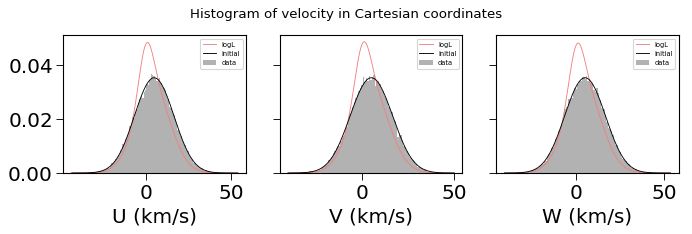

'\nfig = plt.figure(figsize=(16,5))\naxA = fig.add_subplot(1,3,1)\naxA.hist(uvw_gal[:,0], bins=\'auto\', histtype=\'step\', normed=True, label="Simulated UVW")\nx = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)\naxA.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[0], scale=np.sqrt(covars_componentA[0,0])) +\n        amps_true[1]*norm.pdf(x, loc=means_componentB[0], scale=np.sqrt(covars_componentB[0,0])), label="True")\naxA.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,0], scale=np.sqrt(covs_xd[0,0,0])) +\n        amps_xd[1]*norm.pdf(x, loc=means_xd[1,0], scale=np.sqrt(covs_xd[1,0,0])), label="XD")\naxA.set_xlabel(\'$U$ [km/s]\')\naxA.legend(fontsize=12)\n\naxB = fig.add_subplot(1,3,2)\naxB.hist(uvw_gal[:,1], bins=\'auto\', histtype=\'step\', normed=True)\nx = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)\naxB.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[1], scale=np.sqrt(covars_componentA[1,1])) +\n        amps_true[1]*norm.pdf(x, loc=means_compon

In [4]:
def plot_normal_PDF(ax, v, x, amps, means, covs, c, l):
    pdf = np.zeros(len(x))
    for n in range(len(amps)):
        pdf += amps[n]*sp.stats.norm.pdf(x, loc=means[n,v], scale=np.sqrt(covs[n,v,v]))
    ax.plot(x, pdf, label=l, color=c, lw=.8)

def plot_hist_uvw(inita, initm, initc, a_test, m_test, c_test, uvw_data, a_test_vrad0=None, m_test_vrad0=None, c_test_vrad0=None, uvw_data_vrad0=None, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors_vrad0 = 'red' ; colors = 'lightcoral'
    test = 'logL' ; test_vrad0 = 'logL $v_r = 0$'   
    fig, ax = plt.subplots(1, len(velocities), sharey=True, figsize=(9,3), tight_layout=True)
    for v in range(len(velocities)):
        print "v", v
        vrange = np.linspace(np.amin(uvw_data[:,v]), np.amax(uvw_data[:,v]), len(uvw_data[:,v]))
        plot_normal_PDF(ax[v], v, vrange, a_test, m_test, c_test, colors, test) #xd fit
        plot_normal_PDF(ax[v], v, vrange, inita, initm, initc, 'black', 'initial') #curve of initial velocity distribution
        ax[v].hist(uvw_data[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.3, label='data')
        ax[v].set_xlabel(velocities[v] + unit)
        ax[v].legend(loc='upper right', prop={'size': 6})
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity_test.png'
    plt.suptitle(suptitle, y=1., fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()

plot_hist_uvw(amps_true, means_true, covmats_true, amps_xd, means_xd, covs_xd, uvw_gal)

"""
fig = plt.figure(figsize=(16,5))
axA = fig.add_subplot(1,3,1)
axA.hist(uvw_gal[:,0], bins='auto', histtype='step', normed=True, label="Simulated UVW")
x = np.linspace(uvw_gal[:,0].min(), uvw_gal[:,0].max(), 1000)
axA.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[0], scale=np.sqrt(covars_componentA[0,0])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[0], scale=np.sqrt(covars_componentB[0,0])), label="True")
axA.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,0], scale=np.sqrt(covs_xd[0,0,0])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,0], scale=np.sqrt(covs_xd[1,0,0])), label="XD")
axA.set_xlabel('$U$ [km/s]')
axA.legend(fontsize=12)

axB = fig.add_subplot(1,3,2)
axB.hist(uvw_gal[:,1], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,1].min(), uvw_gal[:,1].max(), 1000)
axB.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[1], scale=np.sqrt(covars_componentA[1,1])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[1], scale=np.sqrt(covars_componentB[1,1])) )
axB.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,1], scale=np.sqrt(covs_xd[0,1,1])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,1], scale=np.sqrt(covs_xd[1,1,1])) )
axB.set_xlabel('$V$ [km/s]')

axC = fig.add_subplot(1,3,3)
axC.hist(uvw_gal[:,2], bins='auto', histtype='step', normed=True)
x = np.linspace(uvw_gal[:,2].min(), uvw_gal[:,2].max(), 1000)
axC.plot(x, amps_true[0]*norm.pdf(x, loc=means_componentA[2], scale=np.sqrt(covars_componentA[2,2])) +
        amps_true[1]*norm.pdf(x, loc=means_componentB[2], scale=np.sqrt(covars_componentB[2,2])) )
axC.plot(x, amps_xd[0]*norm.pdf(x, loc=means_xd[0,2], scale=np.sqrt(covs_xd[0,2,2])) +
        amps_xd[1]*norm.pdf(x, loc=means_xd[1,2], scale=np.sqrt(covs_xd[1,2,2])) )
axC.set_xlabel('$W$ [km/s]')

plt.suptitle("XD recovered velocity distribution")
plt.tight_layout(pad=1.8)

plt.show()
"""